# Hedge Fund Holdings Analysis via EDGAR

## 1. Setup and Imports

In [195]:
from sec_edgar_downloader import Downloader
from bs4 import BeautifulSoup
from datetime import datetime

import seaborn as sns
import os
import re
import requests
import unicodedata
import pandas as pd
import csv
import xml.etree.ElementTree as ET
import yfinance as yf
import streamlit as st

In [178]:
dl = Downloader("Narain Nair", "nair4986@gmail.com")
dl.get("13F-HR", "1167483")

95

## 2. Parse and Structure Filing Data

In [179]:
def extract_info_table_xml(txt_file_path):
    """
    Extracts the XML string within <INFORMATIONTABLE> tags from the full .txt filing.
    """
    with open(txt_file_path, 'r', encoding='utf-8', errors='ignore') as f:
        content = f.read()

    # Use regex to extract everything between <INFORMATIONTABLE>...</INFORMATIONTABLE>
    match = re.search(r"<INFORMATIONTABLE[\s\S]*?</INFORMATIONTABLE>", content, re.IGNORECASE)

    if match:
        return match.group(0)
    else:
        return None  # No XML found

In [180]:
def parse_info_table_xml(xml_string):
    """
    Parses the extracted XML string into a list of holdings as a pandas DataFrame.
    """
    xml_string_clean = re.sub(r'\sxmlns="[^"]+"', '', xml_string, count=1)

    root = ET.fromstring(xml_string_clean)

    data = []
    for info in root.findall("infoTable"):
        row = {}
        for child in info:
            if list(child):  # tag has nested children
                for subchild in child:
                    tag = subchild.tag.strip()
                    text = subchild.text.strip() if subchild.text else ''
                    row[tag] = text
            else:
                tag = child.tag.strip()
                text = child.text.strip() if child.text else ''
                row[tag] = text
        data.append(row)

    return pd.DataFrame(data)

In [181]:
def filter_2016(folder_name):
    match = re.search(r'-([0-9]{2})-', folder_name)
    if match:
        year_suffix = int(match.group(1))
        year = 2000 + year_suffix
        return year > 2016
    return False

In [182]:
def extract_date(accession):
    match = re.search(r'(\d{4})(\d{2})(\d{2})', accession)
    if match:
        return f"{match.group(1)}-{match.group(2)}-{match.group(3)}"
    else:
        return accession

In [183]:
## Constructing dictionaries for the holdings and the filings themselves
folder_path = "./sec-edgar-filings/0001167483/13F-HR/"
holdings = []
filings = []

for folder in os.listdir(folder_path):
    if not filter_2016(folder):
        continue

    access_folder_path = os.path.join(folder_path, folder)

    for file in os.listdir(access_folder_path):
        if file.endswith(".txt"):
            file_path = os.path.join(access_folder_path, file)
            print(f"Processing: {file_path}")
            
            xml_str = extract_info_table_xml(file_path)
            if xml_str:
                df = parse_info_table_xml(xml_str)
                df["source_file"] = file
                df["accession"] = folder

                date_match = re.search(r'(\d{4}-\d{2}-\d{2})', folder)  
                if not date_match:
                    date_match = re.search(r'(\d{4}-\d{2}-\d{2})', file)  
                date = date_match.group(1) if date_match else "Unknown"

                filings.append({
                    "date": date,
                    "df": df
                })
                holdings.append(df)

master_holdings_df = pd.concat(holdings, ignore_index=True)

Processing: ./sec-edgar-filings/0001167483/13F-HR/0000919574-20-007148/full-submission.txt
Processing: ./sec-edgar-filings/0001167483/13F-HR/0000919574-24-004713/full-submission.txt
Processing: ./sec-edgar-filings/0001167483/13F-HR/0000919574-18-001706/full-submission.txt
Processing: ./sec-edgar-filings/0001167483/13F-HR/0000919574-22-006727/full-submission.txt
Processing: ./sec-edgar-filings/0001167483/13F-HR/0000919574-20-005337/full-submission.txt
Processing: ./sec-edgar-filings/0001167483/13F-HR/0000919574-18-005626/full-submission.txt
Processing: ./sec-edgar-filings/0001167483/13F-HR/0000919574-23-001481/full-submission.txt
Processing: ./sec-edgar-filings/0001167483/13F-HR/0000919574-21-007099/full-submission.txt
Processing: ./sec-edgar-filings/0001167483/13F-HR/0000919574-25-003217/full-submission.txt
Processing: ./sec-edgar-filings/0001167483/13F-HR/0000919574-19-001612/full-submission.txt
Processing: ./sec-edgar-filings/0001167483/13F-HR/0000919574-24-001349/full-submission.txt

## 3. Data processing & analysis

In [184]:
## Converting some of the columns to numeric datatypes.
cols_for_numeric = ['value', 'sshPrnamt', 'Sole', 'Shared', 'None']
for col in cols_for_numeric:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df['%_allocation'] = 100 * (df['value'] / df['value'].sum())

In [185]:
## Function to extract the filing date from the path.
def filing_date_extraction(path):
    match = re.search(r'(\d{4}-\d{2}-\d{2}', path)
    if match:
        return match.group(1)
    else:
        return None

# 3.1 Portfolio-level metrics

In [186]:
## Calculating the allocation percentage per filing for each holding in portfolio
df = df.dropna(subset=['value'])
total_value = df['value'].sum()

df['allocation_percent'] = (df['value'] / total_value) * 100

In [187]:
## Function to track how the holdings in filings change
def holdings_compare(df_1, df_2):
    prev_set = set(df_1['cusip'])
    curr_set = set(df_2['cusip'])

    new_buys = curr_set - prev_set
    full_exits = prev_set - curr_set
    kept = prev_set & curr_set

    return {
        'new_buys':len(new_buys),
        'exits':len(full_exits),
        'kept':len(kept),
        'total_prev':len(prev_set),
        'total_curr':len(curr_set),
        'turnover_pct':(len(new_buys | full_exits) / ((len(prev_set) + len(curr_set))/2)) * 100
    }

## Dictionary analysing the turnover for each filing
for f in filings:
    f['year'] = int(f['date'].split('-')[1])  

turnover_results = []
year_to_filing = {f['year']: f for f in filings}
sorted_years = sorted(year_to_filing.keys())

## Isolating only consecutive years
for i in range(1, len(sorted_years)):
    prev_year = sorted_years[i-1]
    curr_year = sorted_years[i]

    if curr_year == prev_year + 1:
        prev = year_to_filing[prev_year]
        curr = year_to_filing[curr_year]

        comparison = holdings_compare(prev['df'], curr['df'])
        comparison['period'] = f"{prev['date']} -> {curr['date']}"
        comparison['from_year'] = prev_year
        comparison['to_year'] = curr_year
    
        turnover_results.append(comparison)

## Adding to dataframe 
turnover_df = pd.DataFrame(turnover_results)

In [188]:
## Periods are consecutive, as expected
turnover_df['period']

0    9574-17-00 -> 9574-18-00
1    9574-18-00 -> 9574-19-00
2    9574-19-00 -> 9574-20-00
3    9574-20-00 -> 9574-21-00
4    9574-21-00 -> 9574-22-00
5    9574-22-00 -> 9574-23-00
6    9574-23-00 -> 9574-24-00
7    9574-24-00 -> 9574-25-00
Name: period, dtype: object

In [189]:
print(list(turnover_df.columns))

['new_buys', 'exits', 'kept', 'total_prev', 'total_curr', 'turnover_pct', 'period', 'from_year', 'to_year']


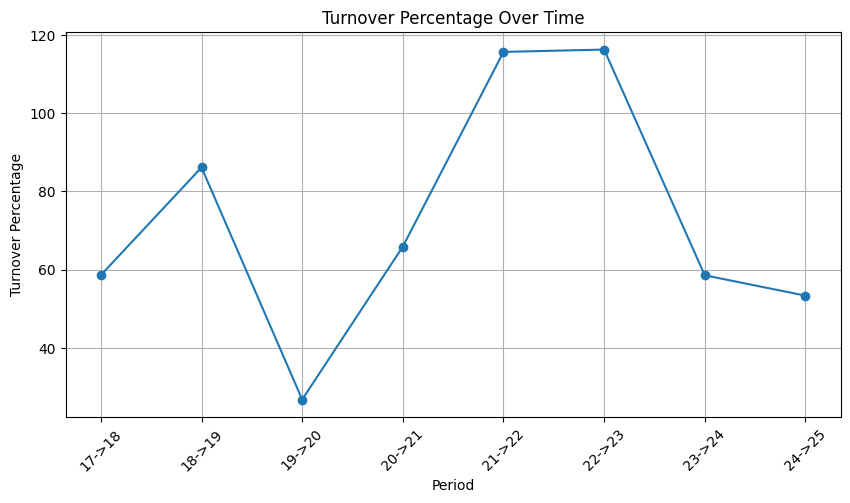

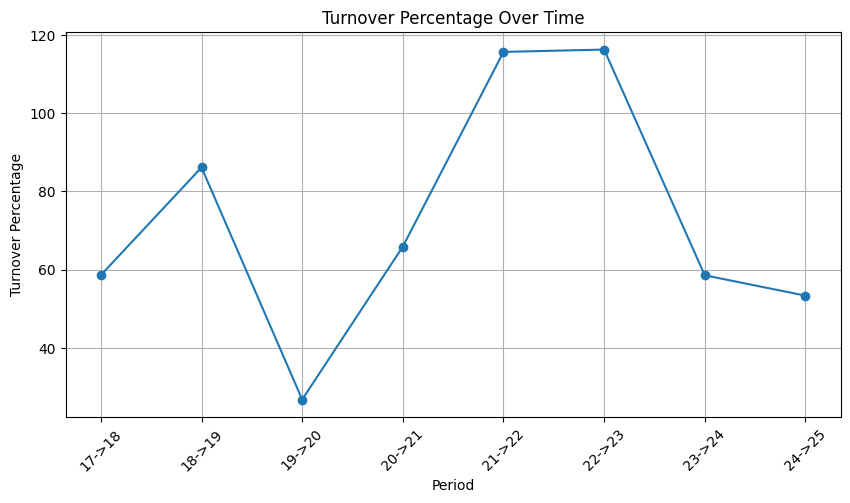

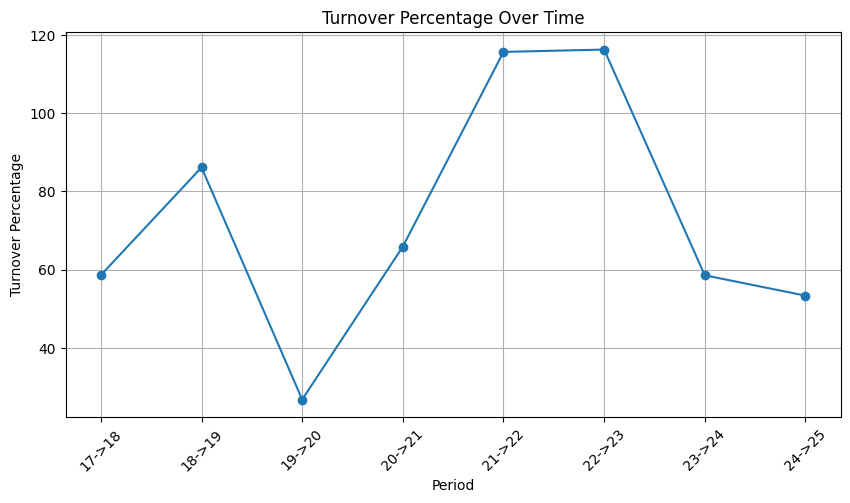

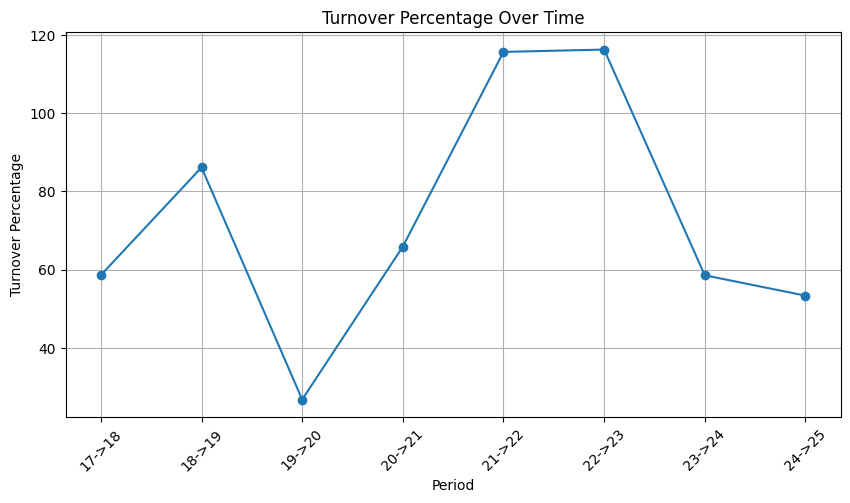

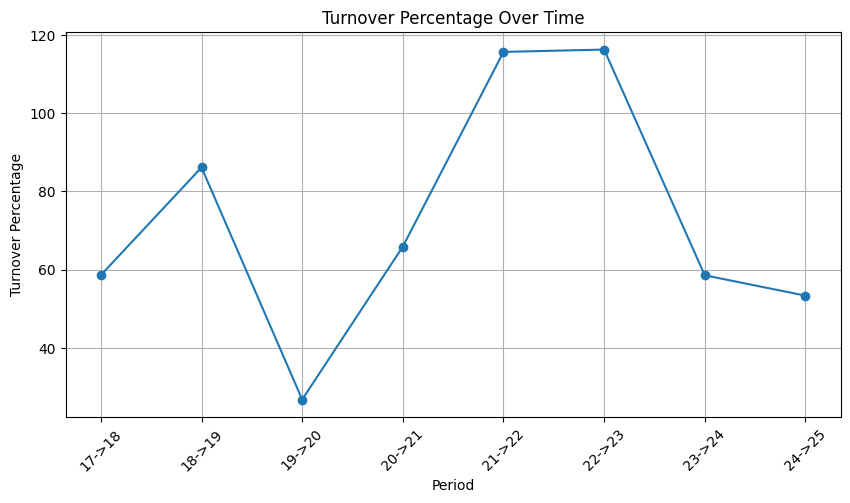

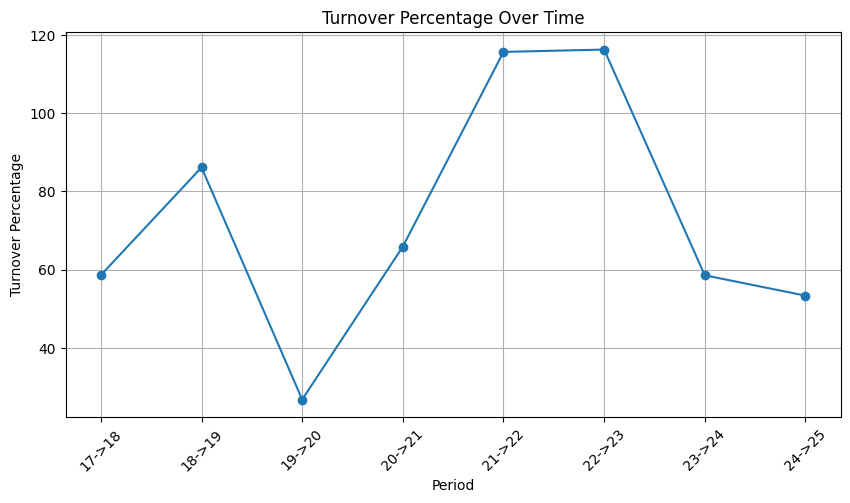

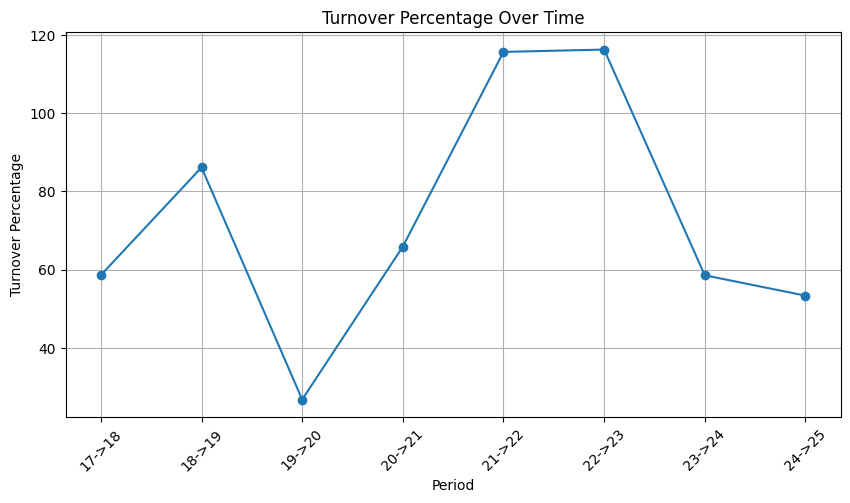

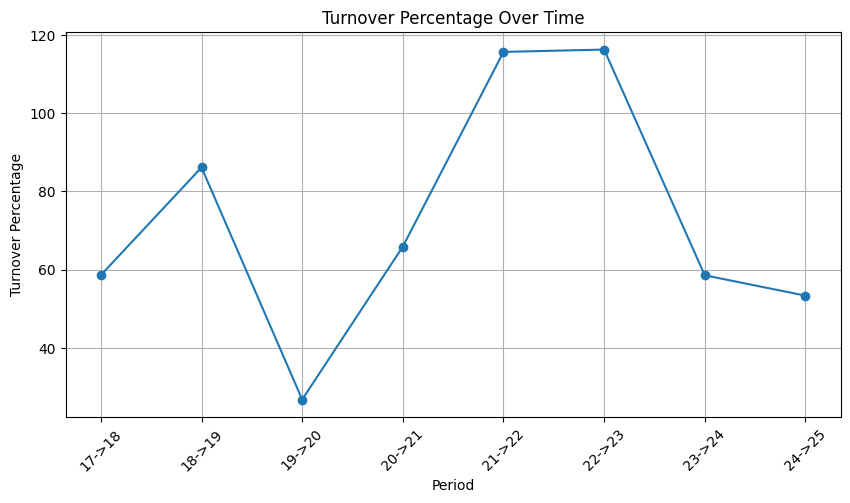

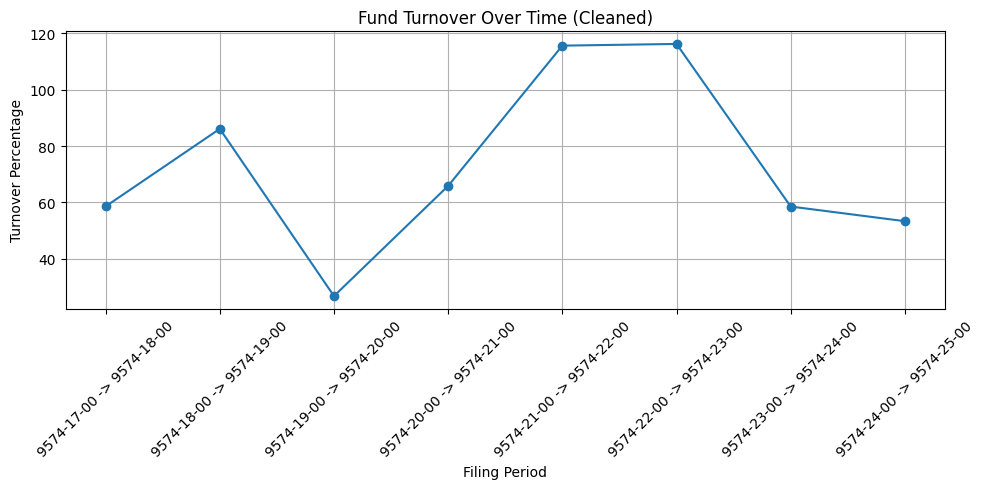

In [190]:
## Line graph to highlight the fund turnover over time, across the whole portfolio.
plt.figure(figsize=(10, 5))
plt.plot(turnover_df['period'], turnover_df['turnover_pct'], marker='o')
plt.xticks(rotation=45)
plt.xlabel("Filing Period")
plt.ylabel("Turnover Percentage")
plt.title("Fund Turnover Over Time (Cleaned)")
plt.grid(True)
plt.tight_layout()
plt.show()

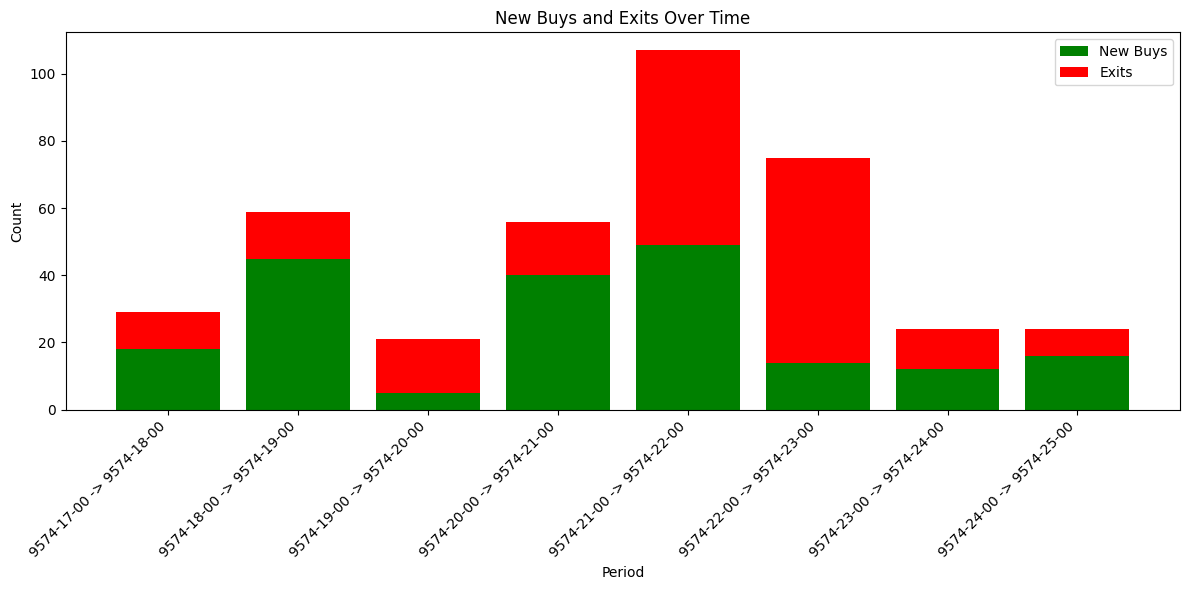

In [191]:
## Stacked bar chart to show new buys & exits over the filing period.
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.bar(turnover_df['period'], turnover_df['new_buys'], label='New Buys', color='green')

plt.bar(turnover_df['period'], turnover_df['exits'], bottom=turnover_df['new_buys'], label='Exits', color='red')

plt.xticks(rotation=45, ha='right')
plt.xlabel('Period')
plt.ylabel('Count')
plt.title('New Buys and Exits Over Time')
plt.legend()
plt.tight_layout()
plt.show()